In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *
import os
import shutil

## Exploratory Data Analysis

In [ ]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

This seems to have worked nicely, so let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [ ]:
bear_types = '0','1','2', '3', '4'
path = Path('gdrive/MyDrive/Polygence/')

In [ ]:
if not path.exists():
  #remove if not path exists
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
 #       results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

for o in bear_types:
  if o == '4':
    continue
  i = 0
  source = (path/o)
  imglist = os.listdir(source)
  while (i < 708):
    initial = str(path/o/imglist[i])
    temp = 'dump'
    dest = (path/temp)
    shutil.move(initial, dest)
    i = i+1

# change path for actual DR model

24694
1735
4584
165
708


Our folder has image files, as we'd expect:

In [ ]:
fns = get_image_files(path)
fns

(#35126) [Path('gdrive/MyDrive/Polygence/train/1/36958_left.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/35807_left.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/35808_left.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/31863_left.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/30146_right.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/35666_right.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/39554_left.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/39033_right.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/31886_right.jpeg'),Path('gdrive/MyDrive/Polygence/train/1/38391_right.jpeg')...]

> j: I just love this about working in Jupyter notebooks! It's so easy to gradually build what I want, and check my work every step of the way. I make a _lot_ of mistakes, so this is really helpful to me...

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('bears/grizzly/dea9dda1-adf1-49b9-912b-cecffecb00f2.jpg'),Path('bears/grizzly/d8016512-db87-4082-a263-4fd1d1ed67e2.jpg'),Path('bears/grizzly/0a71ebee-77e6-480d-b00c-a98d494438f2.jpg')]

To remove all the failed images, you can use `unlink` on each of them. Note that, like most fastai functions that return a collection, `verify_images` returns an object of type `L`, which includes the `map` method. This calls the passed function on each element of the collection:

In [ ]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

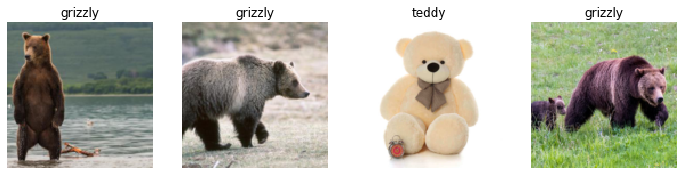

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

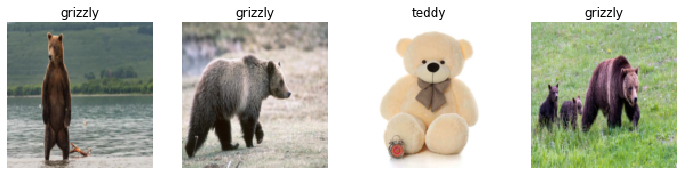

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

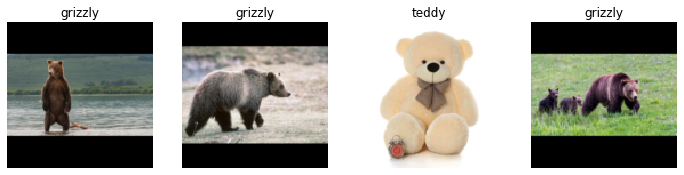

In [ ]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

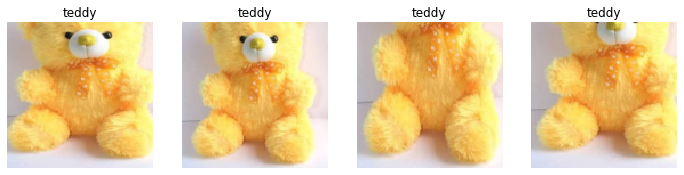

In [ ]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the `aug_transforms` function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter (note that we're not using `RandomResizedCrop` in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

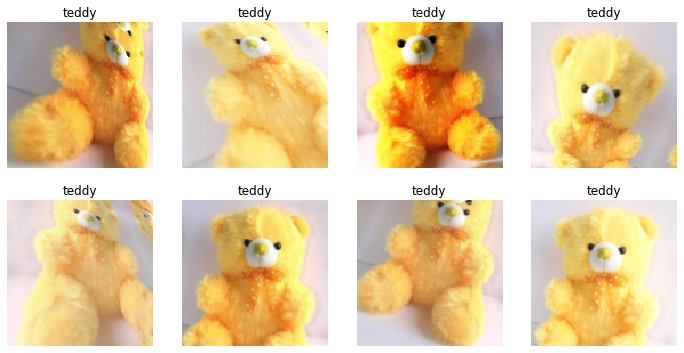

In [ ]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [ ]:
learn = vision_learner(dls, vgg19_bn, metrics=accuracy)
#learn.fine_tune(10)
learn.load('/content/gdrive/MyDrive/Polygence/models/stage-1-vgg19')

Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

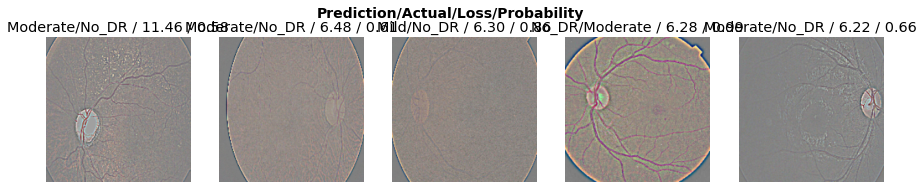

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

<img alt="Cleaner widget" width="700" src="https://github.com/fastai/fastbook/blob/master/images/att_00007.png?raw=1">

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Now that we have trained our model, let's see how we can deploy it to be used in practice.

## Turning Your Model into an Online Application

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [ ]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [ ]:
learn_inf = load_learner('gdrive/MyDrive/Polygence/Resnet50_84%.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [ ]:
learn_inf.predict('gdrive/MyDrive/Polygence/train/3/44200_right.jpeg')

('0',
 TensorBase(0),
 TensorBase([9.8311e-01, 1.3458e-02, 2.4652e-03, 4.1491e-04, 5.4700e-04]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [ ]:
learn_inf.dls.vocab

['0', '1', '2', '3', '4']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook.

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [ ]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

We can use an `Output` widget to display it:

In [ ]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

Then we can get our predictions:

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [ ]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

<img alt="The whole widget" width="233" src="https://github.com/fastai/fastbook/blob/master/images/att_00011.png?raw=1">